In [1]:
import argparse
import os

cpu_num = 1
os.environ ['OMP_NUM_THREADS'] = str(cpu_num)
os.environ ['OPENBLAS_NUM_THREADS'] = str(cpu_num)
os.environ ['MKL_NUM_THREADS'] = str(cpu_num)
os.environ ['VECLIB_MAXIMUM_THREADS'] = str(cpu_num)
os.environ ['NUMEXPR_NUM_THREADS'] = str(cpu_num)

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [2]:
root_path = '/media/drl/datas/zyk/LaneGCN'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [3]:
# ckpt_path = "/home/user/Projects/LaneGCN_modified/results/history_results/raw_map_results/lanegcn_5s/36.000.ckpt"
ckpt_path = "/home/user/Projects/LaneGCN_modified/results/lanegcn/15.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [61]:
# dataset = InteDataset('/home/user/Datasets/interpolated/preprocess_results_5s/test/')
dataset = InteDataset('/home/user/Datasets/with_theta/preprocess_results_5s_use_csv_pairs_5s_scale6/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=0,
    collate_fn=collate_fn,
    shuffle=True,
    pin_memory=True,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
metrics = dict()
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        output = net(data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]

        loss_out = loss(output, data)
        post_out = post_process(output, data)
        post_process.append(metrics, loss_out, post_out)
        break
#     for i, pred_traj in enumerate(results):
#         if i != 0:
#             continue
#         break
#         preds[argo_idx] = pred_traj.squeeze()
#         cities[argo_idx] = data["city"][i]
#         # cities[argo_idx] = "Test"

#         gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None

0it [00:07, ?it/s]


In [ ]:
loss_out.keys()
loss_out['reg_loss']

In [ ]:
# pred_traj
# print(data.keys())
# data['gt_preds'][0].shape
# results[0].shape
# output["reg"][idx][0]
post_process.display(metrics, dt=-1, epoch=-1, lr=None)

In [6]:
def traj_plot(traj, rot, orig, ax, c):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline


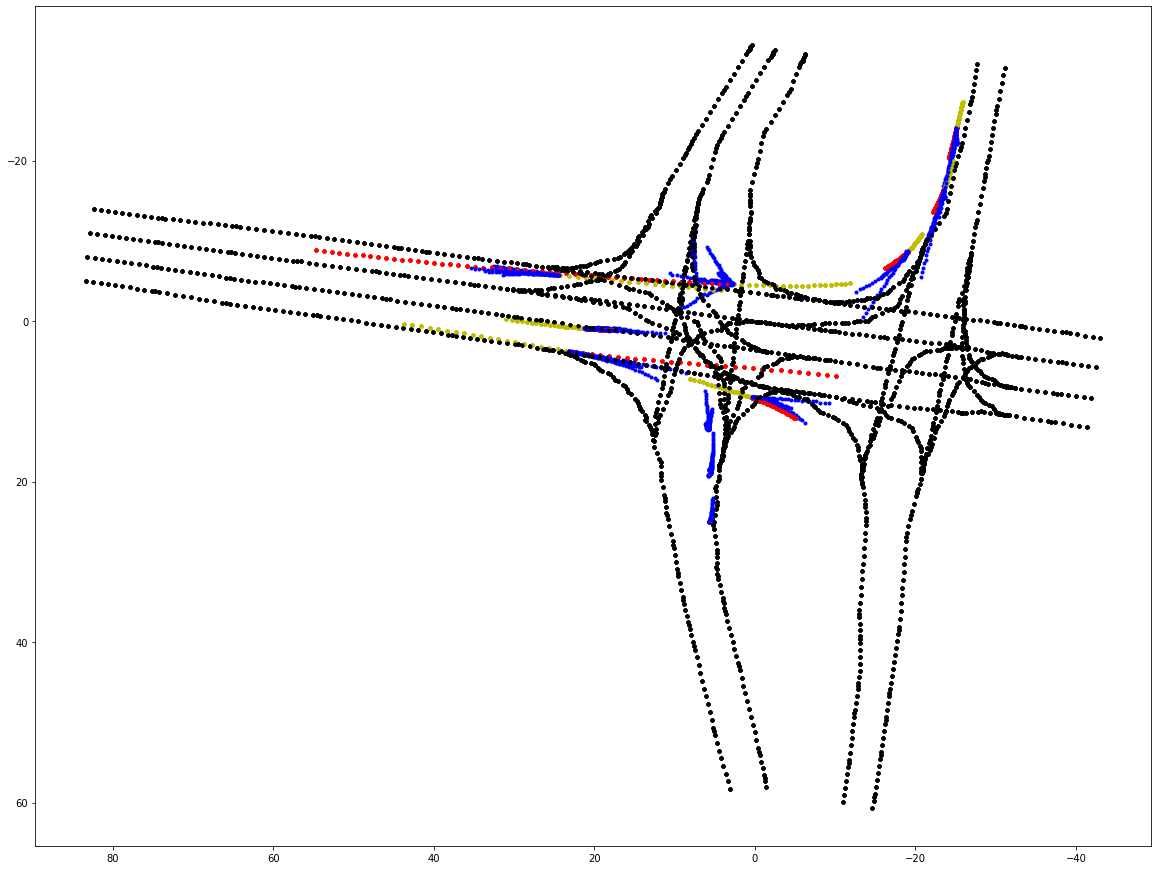

In [69]:
import numpy as np
import matplotlib.pyplot as plt
idx = 10


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]

fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_aspect('equal', adjustable='box')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()  
  
for k in range(6):
    
    for a in range(data['gt_preds'][idx].shape[0]):
        gt_preds = data['gt_preds'][idx][a]
        hist = data['feats'][idx][a]
        plt.plot(hist[:, 0], hist[:, 1], 'y.')
        traj_plot(gt_preds,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
        traj_plot(pred_traj, rot, orig, ax, 'b.')


    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

#     plt.savefig('/home/user/Logs/0702/5scsv_pair/' + str(idx) + '_' + str(k))
plt.show()


In [41]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation(k):
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots()
  dpi = 100
  size_inches = 1000 / dpi
  fig.set_size_inches([size_inches, size_inches])
  plt.ion()

  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

  def animate_func(i):
    for a in range(data['gt_preds'][idx].shape[0]):
        gt_preds = data['gt_preds'][idx][a]
        hist = data['feats'][idx][a]
        if i < 20:
            ax.plot(hist[i, 0], hist[i, 1], 'y.')
        else:
            traj_plot(gt_preds[i-20:i-19],  rot, orig, ax, 'r.')
    
    if i >= 20 and results is not None:
        for a in range(data['gt_preds'][idx].shape[0]):
            traj_plot(results[idx][a, k, i-20:i-19, :], rot, orig, ax, 'b.')
        
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

  anim = animation.FuncAnimation(
      fig, animate_func, frames=50, interval=100)
  plt.close(fig)
  return anim


anim = create_animation(5)
HTML(anim.to_html5_video())

CPU times: user 6.64 s, sys: 254 ms, total: 6.89 s
Wall time: 7.13 s


In [ ]:
print(len(results))
print(results[0].shape)
prediction = torch.tensor(results).permute(0, 2, 1, 3, 4)
prediction.shape

In [ ]:
# for i in range(len(data['gt_preds'])):
#     print(data['gt_preds'][i].shape)

truth = torch.tensor([data['gt_preds'][i].numpy() for i in range(len(data['gt_preds']))])
truth.shape

In [ ]:
torch.arange(prediction.shape[0])
prediction.get_device()

In [ ]:
from metrics import compute_joint_metrics
compute_joint_metrics(prediction, truth, [])